In [53]:
#import libraries
%matplotlib inline
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import files
from load_datas import*
from constants import*
from visualization import*
from data_processing import*
from data_augmentation import*
from preprocessing_helper import *
from post_processing import*
from training_utils import*

# pytorch
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set random seed for reproducibility
torch.manual_seed(0)

In [25]:
imgs, gt_imgs = load_datas(NB_IMAGES_MAX)

imgs_train = imgs[:80]
gt_imgs_train = gt_imgs[:80]
imgs_test = imgs[80:100]
gt_imgs_test = gt_imgs[80:100]

imgs_train.shape
imgs_test.shape

(20, 400, 400, 3)

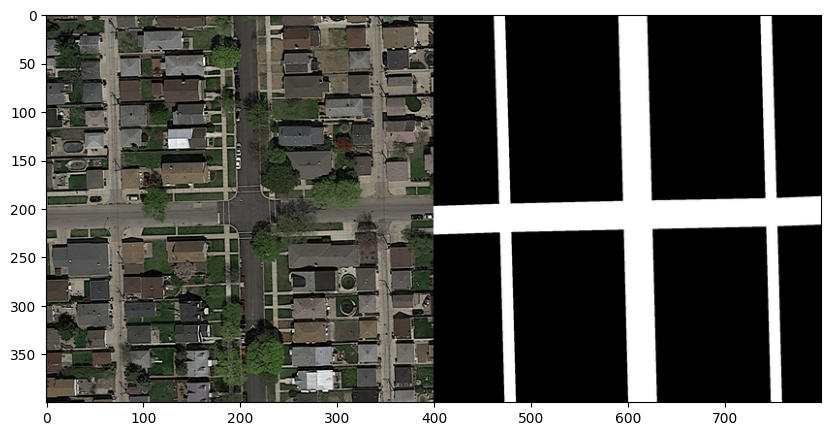

In [5]:
visualize(imgs, gt_imgs)

In [61]:
WINDOW_SIZE = 80

In [63]:
X, y = image_generator(imgs_train, gt_imgs_train, window_size=WINDOW_SIZE, nb_batches=1000, batch_size=32, upsample=True)
# x_val, y_val = image_generator(imgs_test, gt_imgs_test, window_size=WINDOW_SIZE, nb_batches=50, batch_size=32, upsample=True)
x_val, y_val = create_windows_gt(imgs_test, gt_imgs_test, window_size=WINDOW_SIZE)

In [64]:
train_dataloader = DataLoader(
    dataset=list(zip(X, y)),
    batch_size=32,
    shuffle=True,
    num_workers=0)

validate_dataloader = DataLoader(
    dataset=list(zip(x_val, y_val)),
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [66]:
from cnn import *

cnn = Basic_CNN(WINDOW_SIZE)

# Define the loss function, optimizer and scheduler
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Train the model
cnn.train_model(optimizer, scheduler, criterion, train_dataloader, validate_dataloader, num_epochs=10)

Epoch 1/10, Loss: 0.49533727548599243, Validation Accuracy: 0.7666, F1 score: 0.6531
Epoch 2/10, Loss: 0.32919070274949075, Validation Accuracy: 0.8587, F1 score: 0.7257
Epoch 3/10, Loss: 0.32745499172407666, Validation Accuracy: 0.8693, F1 score: 0.7593
Epoch 4/10, Loss: 0.3049783458166022, Validation Accuracy: 0.8722, F1 score: 0.7516
Epoch 5/10, Loss: 0.3105078734272305, Validation Accuracy: 0.8752, F1 score: 0.7730
Epoch 6/10, Loss: 0.40154090682831206, Validation Accuracy: 0.8410, F1 score: 0.7451
Epoch 7/10, Loss: 0.3757923183654829, Validation Accuracy: 0.8565, F1 score: 0.7507
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/10, Loss: 0.3292912722174725, Validation Accuracy: 0.8801, F1 score: 0.7791
Epoch 9/10, Loss: 0.3392906138797442, Validation Accuracy: 0.8807, F1 score: 0.7819
Epoch 10/10, Loss: 0.3408026635199592, Validation Accuracy: 0.8819, F1 score: 0.7787
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.


## Create submission

In [67]:
sub_imgs = load_test_datas()
sub_imgs_patches = create_windows(sub_imgs, window_size=WINDOW_SIZE)

In [68]:
subs_loader = DataLoader(
    dataset=sub_imgs_patches,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [69]:
sub_preds = cnn.predict(test_loader=subs_loader)

In [70]:
images_filenames = save_pred_as_png(sub_preds, len(sub_imgs), PATCH_SIZE, label_to_img)
masks_to_submission('submission.csv', *images_filenames)